In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing
import cv2
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras import layers
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils, to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, BatchNormalization,Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers, optimizers
from keras.applications import DenseNet121
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight, shuffle
from PIL import Image, ImageEnhance

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
BATCH_SIZE = 10
IMG_SIZE = 350

In [3]:
train_data = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_data = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = train_data['id_code']
y = train_data['diagnosis']

x, y = shuffle(x, y, random_state=8)

y = to_categorical(y, num_classes=5)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2,
                                                      stratify=y, random_state=8)

In [4]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def edgeCanny(img):
    
    red,green,blue = cv2.split(img)
    
    final_red = cv2.Canny(red, 5, 205)
    final_red = red + final_red
    
    final_green = cv2.Canny(green, 5, 205)
    final_green = green + final_green
    
    final_blue = cv2.Canny(blue, 5, 205)
    final_blue = blue + final_blue
    
    img = cv2.merge([final_red, final_green, final_blue])
    
    return img
    

def prepare_Images(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (450, 450))
    
    img = crop_image_from_gray(img)
    
    img = edgeCanny(img)
    
    #img = cv2.equalizeHist(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , 35) ,-4 ,128)
    
    return img

In [5]:
N = train_x.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_x)):
    x_train[i, :, :, :] = prepare_Images(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 2929/2929 [14:37<00:00,  3.02it/s]


In [11]:
N = valid_x.shape[0]
x_valid = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(valid_x)):
    x_valid[i, :, :, :] = prepare_Images(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 733/733 [03:45<00:00,  2.49it/s]


In [12]:
print(x_train.shape)
print(train_y.shape)
print(x_valid.shape)
print(valid_y.shape)

(2929, 350, 350, 3)
(2929, 5)
(733, 350, 350, 3)
(733, 5)


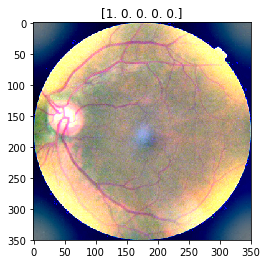

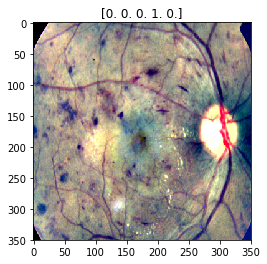

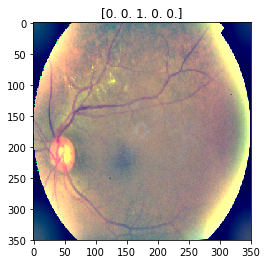

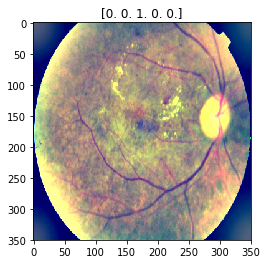

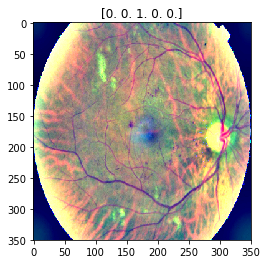

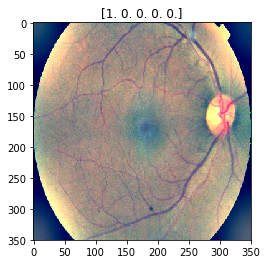

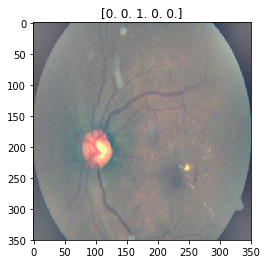

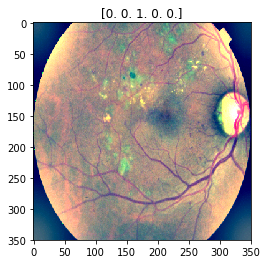

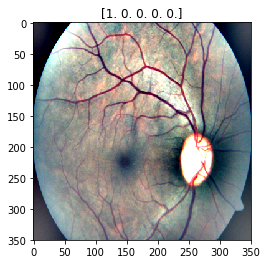

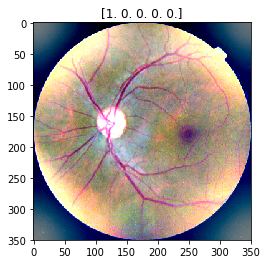

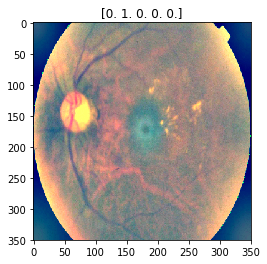

In [56]:
maps = ['Reds', 'Greens', 'Blues']
grid_ind = 1

fig = plt.figure(figsize=(4, 4))
for i,img in enumerate(x_valid):
    plt.imshow(img, cmap=maps[ind])
    plt.title(valid_y[i])
    plt.show()
    if(i == 10):
        break

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, train_y, batch_size=BATCH_SIZE)

In [ ]:
#Building model
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(150,activation='relu'))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(150,activation='relu'))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(150,activation='relu'))
    model.add(BatchNormalization())
    
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    for layer in model.layers:
        layer.trainable=True
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

model = build_model()

model.summary()

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=6, 
                                   verbose=1, mode='auto', epsilon=0.0001)
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.adam(lr=0.0001), metrics=['accuracy'])
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_valid, valid_y),
    callbacks=[es, reduceLR]
)

In [ ]:
pred = model.predict(x_valid)

from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(valid_y.argmax(axis=1), pred.argmax(axis=1)),2)
print(score)
report = classification_report(valid_y.argmax(axis=1), pred.argmax(axis=1))
print(report)
conMat = confusion_matrix(valid_y.argmax(axis=1),pred.argmax(axis=1))
print(conMat)

In [ ]:
del x_train
del x_valid
# Any results you write to the current directory are saved as output.
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
test_df.head()

x = test_df['id_code']
test_Dataset = []
def make_test_data(path):
    img=prepare_Images(path)
    test_Dataset.append(img)

for id_code in tqdm(x):
    path = os.path.join('../input/aptos2019-blindness-detection/test_images','{}.png'.format(id_code))
    make_test_data(path)
test_image = np.array(test_Dataset)
pred=model.predict(test_image)
pred=np.argmax(pred,axis=1)
pred

sub_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sub_df.head()

sub_df.diagnosis = pred
sub_df.head()

sub_df.to_csv("submission.csv",index=False)

In [ ]:
plt.hist(sub_df.diagnosis)
plt.show()